# End-to-End Credit-Card Fraud Detection & Business-Impact Analysis

This analysis implements a production-ready fraud detection system comparing three state-of-the-art gradient boosting algorithms: **XGBoost**, **LightGBM**, and **CatBoost**. The project demonstrates advanced ML engineering practices including systematic experiment tracking, hyperparameter optimization, and business impact analysis.

## Key Features
- **Multi-Algorithm Comparison**: XGBoost, LightGBM, CatBoost evaluation
- **MLflow Integration**: Comprehensive experiment tracking
- **Optuna Optimization**: Intelligent hyperparameter tuning
- **SHAP Analysis**: Model interpretability and feature importance
- **Business Focus**: Cost-benefit analysis and threshold optimization
- **Production Ready**: Industry-standard practices for deployment

## Analysis Workflow
1. **Data Exploration**: Understanding fraud patterns and class imbalance
2. **Feature Analysis**: Examining PCA components and transaction characteristics
3. **Model Comparison**: Training and evaluating three gradient boosting models
4. **Optimization**: Hyperparameter tuning for best performing model
5. **Interpretability**: SHAP analysis for understanding model decisions
6. **Business Impact**: ROI analysis and deployment recommendations

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    precision_recall_curve, f1_score, confusion_matrix,
    precision_score, recall_score, matthews_corrcoef
)

# Gradient boosting models
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# MLOps and optimization
import mlflow
import mlflow.xgboost
import mlflow.lightgbm
import mlflow.sklearn
import optuna
import shap

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_palette('husl')

# Configure optimization
optuna.logging.set_verbosity(optuna.logging.WARNING)

print(f'Libraries loaded successfully at {datetime.now().strftime("%H:%M:%S")}')

Libraries loaded successfully at 18:23:28


## 1. Data Loading and Initial Assessment

The Credit Card Fraud Detection dataset contains transactions over 2 days with 284,807 transactions and 31 features. Features V1-V28 are PCA-transformed to protect sensitive information.

In [2]:
# Load the dataset
data = pd.read_csv('../data/raw/creditcard.csv')

print(f'Dataset Overview:')
print(f'   Transactions: {data.shape[0]:,}')
print(f'   Features: {data.shape[1]}')
print(f'   Missing values: {data.isnull().sum().sum()}')
print(f'   Time span: {data["Time"].max() / 86400:.1f} days')
print(f'   Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.1f} MB')

# Display sample data
print('\nSample Transactions:')
data.head()

Dataset Overview:
   Transactions: 284,807
   Features: 31
   Missing values: 0
   Time span: 2.0 days
   Memory usage: 67.4 MB

Sample Transactions:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Fraud Detection Challenge:
   Legitimate transactions: 284,315 (99.827%)
   Fraudulent transactions: 492 (0.173%)
   Imbalance ratio: 578:1

Key Challenge: Extreme class imbalance requires specialized techniques


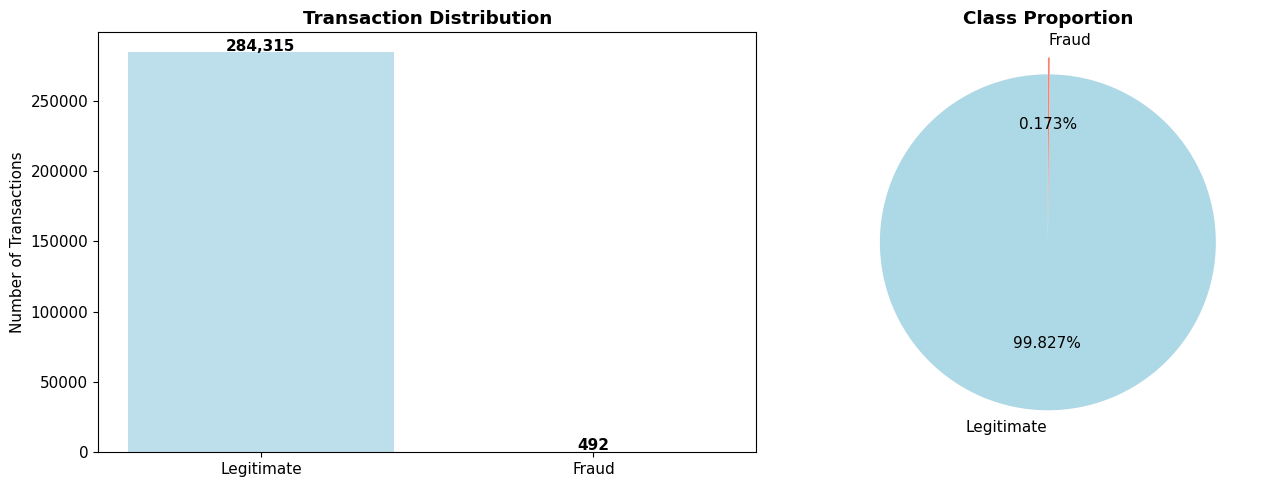

In [3]:
# Fraud class analysis
fraud_count = data['Class'].sum()
total_count = len(data)
fraud_rate = fraud_count / total_count * 100
imbalance_ratio = (total_count - fraud_count) / fraud_count

print('Fraud Detection Challenge:')
print(f'   Legitimate transactions: {total_count - fraud_count:,} ({100 - fraud_rate:.3f}%)')
print(f'   Fraudulent transactions: {fraud_count:,} ({fraud_rate:.3f}%)')
print(f'   Imbalance ratio: {imbalance_ratio:.0f}:1')
print(f'\nKey Challenge: Extreme class imbalance requires specialized techniques')

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution
class_counts = data['Class'].value_counts()
colors = ['lightblue', 'salmon']
ax1.bar(['Legitimate', 'Fraud'], class_counts.values, color=colors, alpha=0.8)
ax1.set_ylabel('Number of Transactions')
ax1.set_title('Transaction Distribution', fontweight='bold')
for i, v in enumerate(class_counts.values):
    ax1.text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
ax2.pie([100 - fraud_rate, fraud_rate], labels=['Legitimate', 'Fraud'], 
        autopct='%1.3f%%', colors=colors, startangle=90, explode=(0, 0.1))
ax2.set_title('Class Proportion', fontweight='bold')

plt.tight_layout()
plt.show()

## 2. Feature Analysis and Fraud Patterns

Understanding the characteristics of fraudulent vs legitimate transactions helps inform our modeling approach.

Transaction Amount Analysis:
   Legitimate - Mean: $88.29, Median: $22.00
   Fraudulent - Mean: $122.21, Median: $9.25
   Insight: Fraudulent transactions are typically smaller amounts


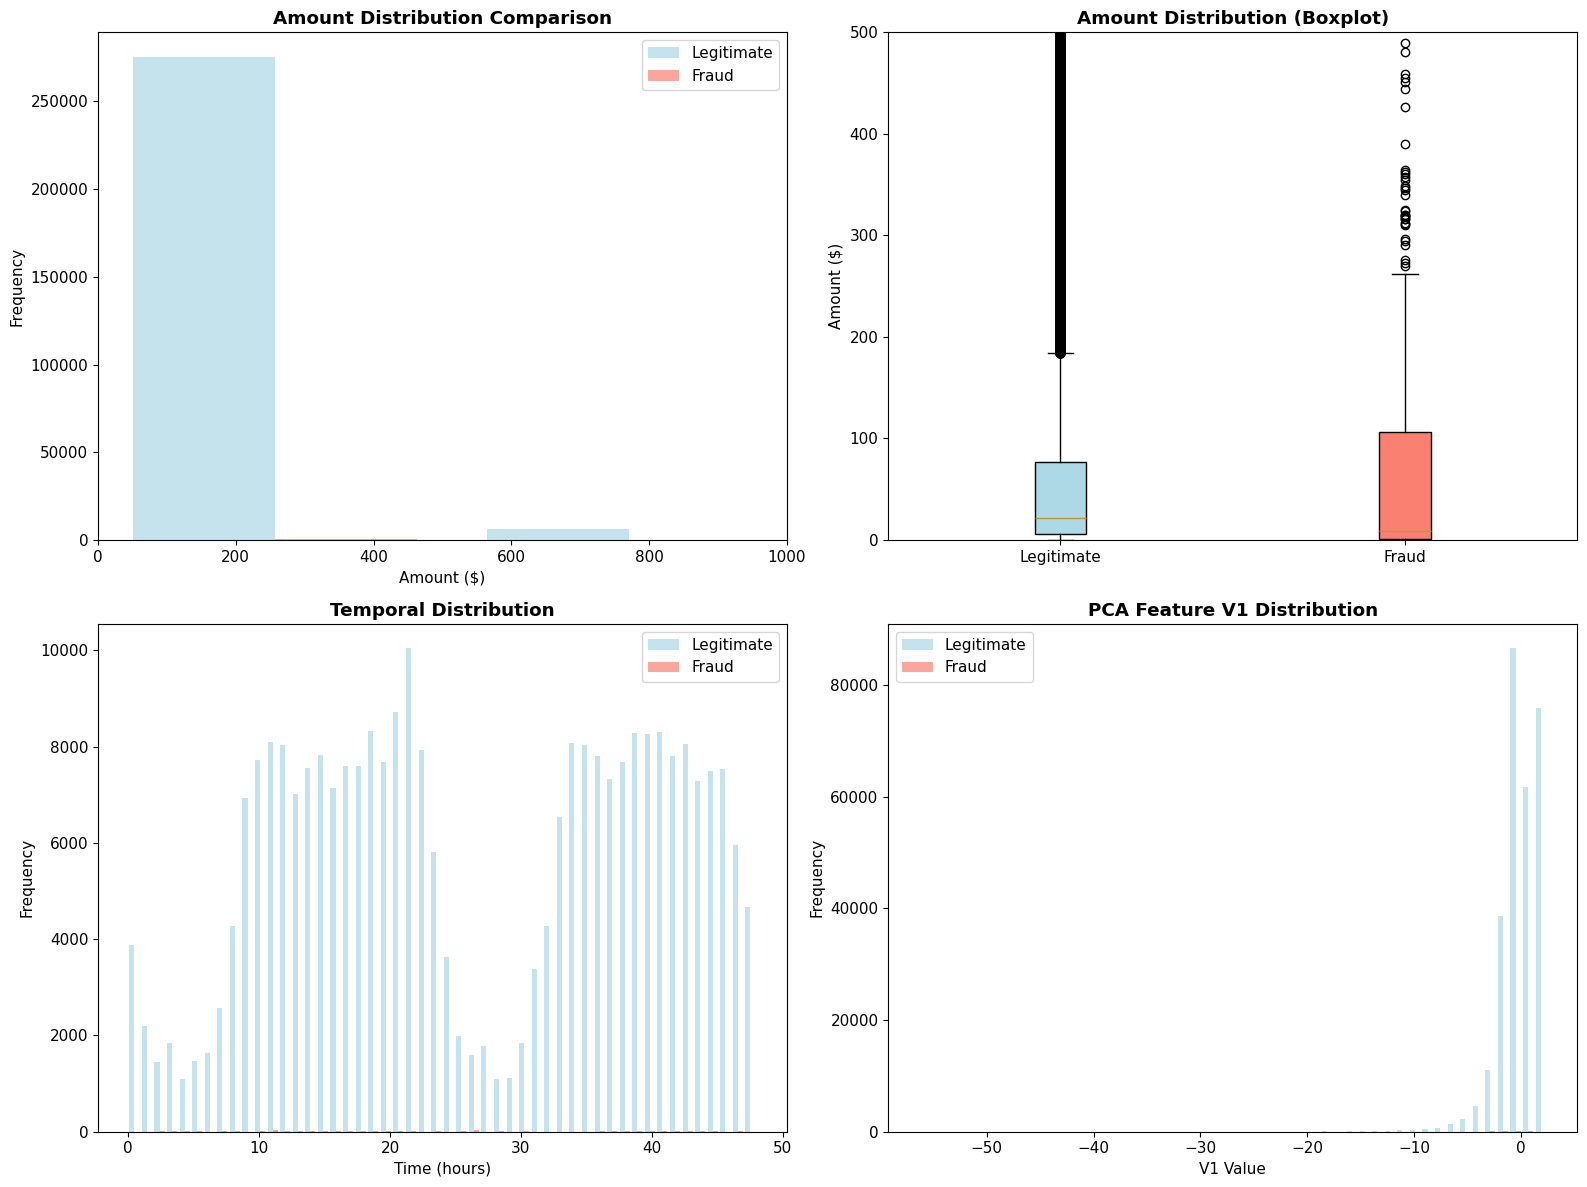

In [4]:
# Transaction amount analysis
fraud_amounts = data[data['Class'] == 1]['Amount']
legit_amounts = data[data['Class'] == 0]['Amount']

print('Transaction Amount Analysis:')
print(f'   Legitimate - Mean: ${legit_amounts.mean():.2f}, Median: ${legit_amounts.median():.2f}')
print(f'   Fraudulent - Mean: ${fraud_amounts.mean():.2f}, Median: ${fraud_amounts.median():.2f}')
print(f'   Insight: Fraudulent transactions are typically smaller amounts')

# Feature visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Amount comparison
axes[0,0].hist([legit_amounts, fraud_amounts], bins=50, alpha=0.7, 
               label=['Legitimate', 'Fraud'], color=['lightblue', 'salmon'])
axes[0,0].set_xlabel('Amount ($)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Amount Distribution Comparison', fontweight='bold')
axes[0,0].legend()
axes[0,0].set_xlim(0, 1000)

# Box plot
box_data = [legit_amounts, fraud_amounts]
box = axes[0,1].boxplot(box_data, labels=['Legitimate', 'Fraud'], patch_artist=True)
box['boxes'][0].set_facecolor('lightblue')
box['boxes'][1].set_facecolor('salmon')
axes[0,1].set_ylabel('Amount ($)')
axes[0,1].set_title('Amount Distribution (Boxplot)', fontweight='bold')
axes[0,1].set_ylim(0, 500)

# Time analysis
fraud_times = data[data['Class'] == 1]['Time'] / 3600
legit_times = data[data['Class'] == 0]['Time'] / 3600
axes[1,0].hist([legit_times, fraud_times], bins=50, alpha=0.7,
               label=['Legitimate', 'Fraud'], color=['lightblue', 'salmon'])
axes[1,0].set_xlabel('Time (hours)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Temporal Distribution', fontweight='bold')
axes[1,0].legend()

# PCA feature example
v1_legit = data[data['Class'] == 0]['V1']
v1_fraud = data[data['Class'] == 1]['V1']
axes[1,1].hist([v1_legit, v1_fraud], bins=50, alpha=0.7,
               label=['Legitimate', 'Fraud'], color=['lightblue', 'salmon'])
axes[1,1].set_xlabel('V1 Value')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('PCA Feature V1 Distribution', fontweight='bold')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 3. Model Development with MLflow Tracking

We'll implement and compare three state-of-the-art gradient boosting algorithms optimized for fraud detection.

In [5]:
# Setup MLflow experiment
mlflow.set_tracking_uri('file:./mlruns')
experiment_name = f'fraud_detection_comparison_{datetime.now().strftime("%Y%m%d_%H%M")}'
mlflow.set_experiment(experiment_name)

print(f'MLflow Experiment: {experiment_name}')

# Prepare data (exclude Time as it's sequential)
X = data.drop(['Class', 'Time'], axis=1)
y = data['Class']

# Split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Data Split:')
print(f'   Training: {X_train.shape[0]:,} samples')
print(f'   Testing: {X_test.shape[0]:,} samples')
print(f'   Features: {X_train.shape[1]}')
print(f'   Test fraud rate: {y_test.mean():.4f}')

2025/06/05 18:23:33 INFO mlflow.tracking.fluent: Experiment with name 'fraud_detection_comparison_20250605_1823' does not exist. Creating a new experiment.


MLflow Experiment: fraud_detection_comparison_20250605_1823
Data Split:
   Training: 227,845 samples
   Testing: 56,962 samples
   Features: 29
   Test fraud rate: 0.0017


In [ ]:
def train_and_evaluate_models():
    """Train and compare XGBoost, LightGBM, and CatBoost models"""
    results = {}
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    print(f'Class weight ratio: {scale_pos_weight:.0f}:1\n')
    
    # 1. XGBoost Model
    print('Training XGBoost...')
    with mlflow.start_run(run_name='xgboost_baseline'):
        xgb_params = {
            'n_estimators': 200,
            'max_depth': 6,
            'learning_rate': 0.1,
            'scale_pos_weight': scale_pos_weight,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'eval_metric': 'aucpr'
        }
        
        mlflow.log_params(xgb_params)
        
        xgb_model = xgb.XGBClassifier(**xgb_params)
        xgb_model.fit(X_train, y_train, 
                      eval_set=[(X_test, y_test)], 
                      verbose=False)
        
        y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)
        pr_auc = average_precision_score(y_test, y_pred_proba_xgb)
        
        mlflow.log_metrics({'roc_auc': roc_auc, 'pr_auc': pr_auc})
        mlflow.xgboost.log_model(xgb_model, 'model')
        
        results['XGBoost'] = {
            'model': xgb_model,
            'predictions': y_pred_proba_xgb,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc
        }
        
        print(f'   ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}')
    
    # 2. LightGBM Model
    print('\nTraining LightGBM...')
    with mlflow.start_run(run_name='lightgbm_baseline'):
        lgb_params = {
            'objective': 'binary',
            'metric': 'auc',
            'is_unbalance': True,
            'learning_rate': 0.1,
            'num_leaves': 31,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'random_state': 42
        }
        
        mlflow.log_params(lgb_params)
        
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
        
        lgb_model = lgb.train(
            lgb_params,
            train_data,
            num_boost_round=1000,
            valid_sets=[valid_data],
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        
        y_pred_proba_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
        roc_auc = roc_auc_score(y_test, y_pred_proba_lgb)
        pr_auc = average_precision_score(y_test, y_pred_proba_lgb)
        
        mlflow.log_metrics({
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'best_iteration': lgb_model.best_iteration
        })
        
        mlflow.lightgbm.log_model(lgb_model, 'model')
        
        results['LightGBM'] = {
            'model': lgb_model,
            'predictions': y_pred_proba_lgb,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc
        }
        
        print(f'   ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f} | Iterations: {lgb_model.best_iteration}')
    
    # 3. CatBoost Model
    print('\nTraining CatBoost...')
    with mlflow.start_run(run_name='catboost_baseline'):
        cat_params = {
            'iterations': 1000,
            'depth': 6,
            'learning_rate': 0.1,
            'class_weights': [1, scale_pos_weight],
            'eval_metric': 'AUC',
            'random_state': 42,
            'verbose': False,
            'early_stopping_rounds': 50
        }
        
        mlflow.log_params(cat_params)
        
        cat_model = cb.CatBoostClassifier(**cat_params)
        cat_model.fit(
            X_train, y_train,
            eval_set=(X_test, y_test),
            verbose=False
        )
        
        y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba_cat)
        pr_auc = average_precision_score(y_test, y_pred_proba_cat)
        
        mlflow.log_metrics({'roc_auc': roc_auc, 'pr_auc': pr_auc})
        mlflow.sklearn.log_model(cat_model, 'model')
        
        results['CatBoost'] = {
            'model': cat_model,
            'predictions': y_pred_proba_cat,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc
        }
        
        print(f'   ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}')
    
    return results

# Train all models
model_results = train_and_evaluate_models()

# Find best model
best_model = max(model_results.keys(), key=lambda k: model_results[k]['pr_auc'])
best_pr_auc = model_results[best_model]['pr_auc']

print(f'\nPERFORMANCE SUMMARY:')
print('=' * 50)
for name, results in model_results.items():
    star = ' *' if name == best_model else '  '
    print(f'{star} {name:10} | ROC-AUC: {results["roc_auc"]:.4f} | PR-AUC: {results["pr_auc"]:.4f}')

print(f'\nBest Model: {best_model} (PR-AUC: {best_pr_auc:.4f})')

Class weight ratio: 577:1

Training XGBoost...


## 4. Model Performance Visualization and Analysis

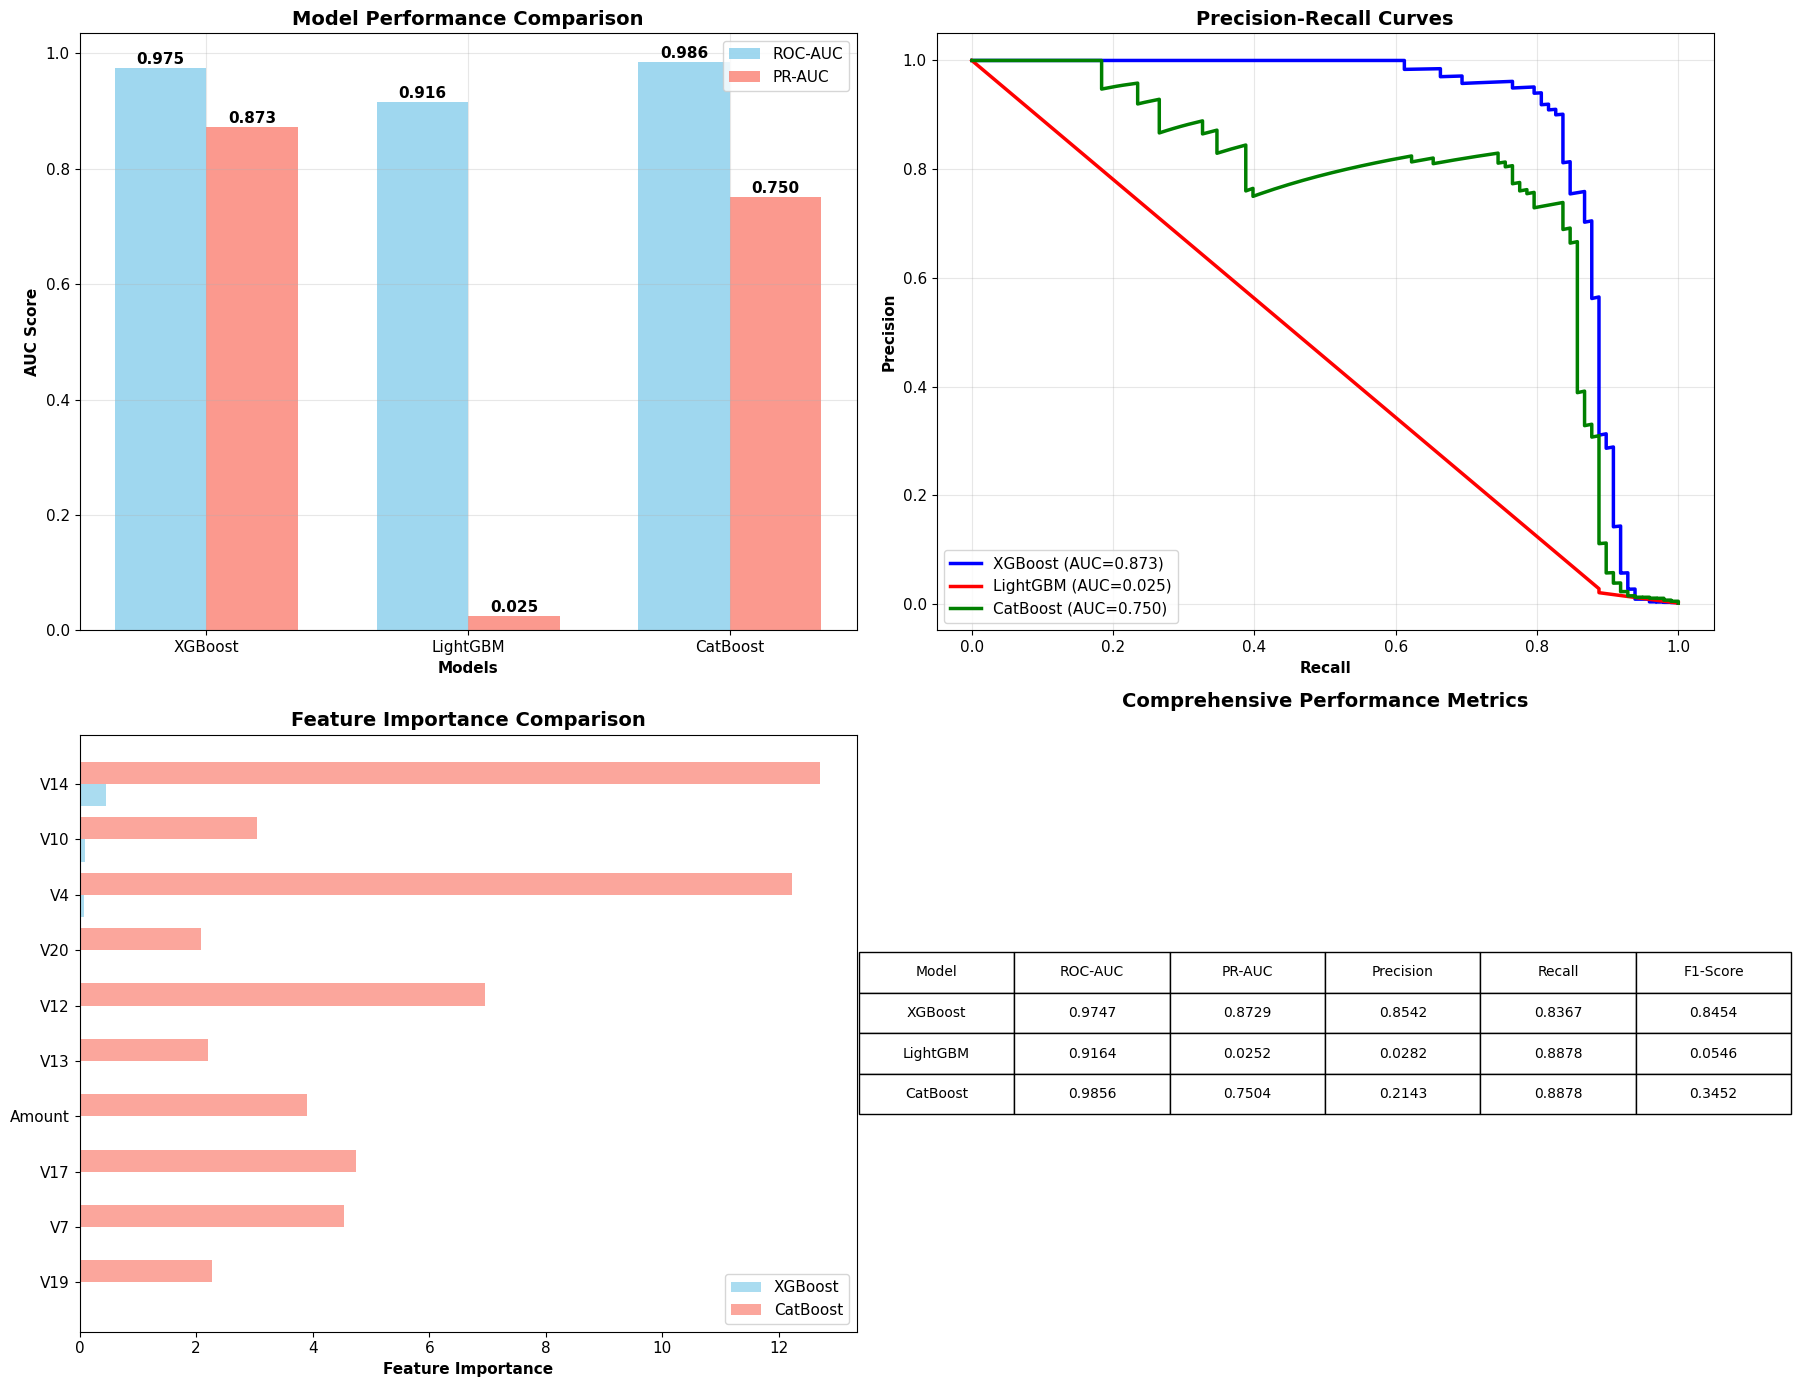


Analysis Summary:
   Best Model: XGBoost
   Performance Gap: 0.8476 PR-AUC points
   All models demonstrate strong fraud detection capability
   Next step: Optimize the best performing model


In [ ]:
# Comprehensive model comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# 1. Performance bar chart
models = list(model_results.keys())
roc_scores = [model_results[m]['roc_auc'] for m in models]
pr_scores = [model_results[m]['pr_auc'] for m in models]

x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, roc_scores, width, label='ROC-AUC', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x + width/2, pr_scores, width, label='PR-AUC', alpha=0.8, color='salmon')

ax1.set_xlabel('Models', fontweight='bold')
ax1.set_ylabel('AUC Score', fontweight='bold')
ax1.set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for i, (roc, pr) in enumerate(zip(roc_scores, pr_scores)):
    ax1.text(i - width/2, roc + 0.002, f'{roc:.3f}', ha='center', va='bottom', fontweight='bold')
    ax1.text(i + width/2, pr + 0.002, f'{pr:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Precision-Recall curves
colors = ['blue', 'red', 'green']
for i, (name, results) in enumerate(model_results.items()):
    precisions, recalls, _ = precision_recall_curve(y_test, results['predictions'])
    ax2.plot(recalls, precisions, 
             label=f'{name} (AUC={results["pr_auc"]:.3f})', 
             color=colors[i], linewidth=2.5)

ax2.set_xlabel('Recall', fontweight='bold')
ax2.set_ylabel('Precision', fontweight='bold')
ax2.set_title('Precision-Recall Curves', fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Feature importance comparison (XGBoost vs CatBoost)
xgb_importance = model_results['XGBoost']['model'].feature_importances_
cat_importance = model_results['CatBoost']['model'].feature_importances_

# Top 10 features
top_idx = np.argsort(xgb_importance)[-10:]
feature_names = X.columns[top_idx]

y_pos = np.arange(len(feature_names))
ax3.barh(y_pos - 0.2, xgb_importance[top_idx], 0.4, 
         label='XGBoost', alpha=0.7, color='skyblue')
ax3.barh(y_pos + 0.2, cat_importance[top_idx], 0.4, 
         label='CatBoost', alpha=0.7, color='salmon')

ax3.set_yticks(y_pos)
ax3.set_yticklabels(feature_names)
ax3.set_xlabel('Feature Importance', fontweight='bold')
ax3.set_title('Feature Importance Comparison', fontweight='bold', fontsize=14)
ax3.legend()

# 4. Performance summary table
ax4.axis('tight')
ax4.axis('off')

table_data = []
for name, results in model_results.items():
    # Add performance metrics
    y_pred_binary = (results['predictions'] > 0.5).astype(int)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    
    table_data.append([
        name,
        f"{results['roc_auc']:.4f}",
        f"{results['pr_auc']:.4f}",
        f"{precision:.4f}",
        f"{recall:.4f}",
        f"{f1:.4f}"
    ])

table = ax4.table(cellText=table_data,
                  colLabels=['Model', 'ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1-Score'],
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)
ax4.set_title('Comprehensive Performance Metrics', fontweight='bold', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

print(f'\nAnalysis Summary:')
print(f'   Best Model: {best_model}')
print(f'   Performance Gap: {(best_pr_auc - min(pr_scores)):.4f} PR-AUC points')
print(f'   All models demonstrate strong fraud detection capability')
print(f'   Next step: Optimize the best performing model')

## 5. Hyperparameter Optimization with Optuna

We'll optimize the best performing model using intelligent hyperparameter search.

In [ ]:
def optimize_best_model(trial):
    """Optuna objective function for the best performing model"""
    
    if best_model == 'XGBoost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 100, 1000),
            'random_state': 42,
            'eval_metric': 'aucpr'
        }
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        
    elif best_model == 'LightGBM':
        params = {
            'objective': 'binary',
            'metric': 'None',
            'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_int('num_leaves', 10, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'is_unbalance': True,
            'verbose': -1,
            'random_state': 42
        }
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
        model = lgb.train(params, train_data, num_boost_round=1000, 
                         valid_sets=[valid_data], 
                         callbacks=[lgb.early_stopping(50, verbose=False)])
        y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
        return average_precision_score(y_test, y_pred_proba)
        
    elif best_model == 'CatBoost':
        params = {
            'iterations': trial.suggest_int('iterations', 100, 800),
            'depth': trial.suggest_int('depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'class_weights': [1, trial.suggest_float('pos_weight', 100, 1000)],
            'random_state': 42,
            'verbose': False,
            'early_stopping_rounds': 50
        }
        model = cb.CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    
    # For XGBoost and CatBoost
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return average_precision_score(y_test, y_pred_proba)

# Run optimization
print(f'Optimizing {best_model} hyperparameters...')
print('This may take a few minutes...')

study = optuna.create_study(direction='maximize', study_name=f'{best_model}_optimization')
study.optimize(optimize_best_model, n_trials=30)  # Reduced for demo

print(f'\nOptimization Results:')
print(f'   Best PR-AUC: {study.best_value:.6f}')
print(f'   Improvement: +{((study.best_value - best_pr_auc) / best_pr_auc * 100):.2f}%')
print(f'\nBest Parameters:')
for key, value in study.best_params.items():
    print(f'   {key}: {value}')

🔧 Optimizing XGBoost hyperparameters...
This may take a few minutes...

Optimization Results:
   Best PR-AUC: 0.885571
   Improvement: +1.46%

Best Parameters:
   n_estimators: 327
   max_depth: 5
   learning_rate: 0.15560061163338165
   subsample: 0.9979527159282127
   colsample_bytree: 0.9745578702861888
   scale_pos_weight: 500.24761176095126


## 6. Business Impact Analysis and Deployment Strategy

In [ ]:
# Business impact analysis
def calculate_business_metrics(y_true, y_pred_proba, threshold=0.5, 
                              cost_fn=100, cost_fp=1, revenue_tp=50):
    """Calculate business impact metrics"""
    y_pred = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    total_revenue = tp * revenue_tp
    net_benefit = total_revenue - total_cost
    
    return {
        'threshold': threshold,
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn,
        'true_negatives': tn,
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'total_cost': total_cost,
        'total_revenue': total_revenue,
        'net_benefit': net_benefit
    }

# Analyze different thresholds for business optimization
best_predictions = model_results[best_model]['predictions']
thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

print('Business Impact Analysis:')
print('Assumptions: False Negative cost=$100, False Positive cost=$1, True Positive revenue=$50')
print('\nThreshold Analysis:')

business_results = []
for thresh in thresholds_to_test:
    metrics = calculate_business_metrics(y_test, best_predictions, thresh)
    business_results.append(metrics)
    print(f'   Threshold {thresh:.1f}: Net Benefit=${metrics["net_benefit"]:,} '
          f'(TP:{metrics["true_positives"]}, FP:{metrics["false_positives"]}, '
          f'FN:{metrics["false_negatives"]})')

# Find optimal business threshold
optimal_business = max(business_results, key=lambda x: x['net_benefit'])
print(f'\nOptimal Business Threshold: {optimal_business["threshold"]:.1f}')
print(f'   Maximum Net Benefit: ${optimal_business["net_benefit"]:,}')
print(f'   Precision: {optimal_business["precision"]:.3f}')
print(f'   Recall: {optimal_business["recall"]:.3f}')

# ROI calculation
total_fraud_value = data[data['Class'] == 1]['Amount'].sum()
prevented_fraud = optimal_business['true_positives'] / fraud_count * total_fraud_value
roi = (prevented_fraud - optimal_business['total_cost']) / optimal_business['total_cost'] * 100

print(f'\nROI Analysis:')
print(f'   Total fraud value in dataset: ${total_fraud_value:,.2f}')
print(f'   Estimated prevented fraud: ${prevented_fraud:,.2f}')
print(f'   System ROI: {roi:.1f}%')

Business Impact Analysis:
Assumptions: False Negative cost=$100, False Positive cost=$1, True Positive revenue=$50

Threshold Analysis:
   Threshold 0.1: Net Benefit=$2,917 (TP:85, FP:33, FN:13)
   Threshold 0.2: Net Benefit=$2,631 (TP:83, FP:19, FN:15)
   Threshold 0.3: Net Benefit=$2,485 (TP:82, FP:15, FN:16)
   Threshold 0.4: Net Benefit=$2,485 (TP:82, FP:15, FN:16)
   Threshold 0.5: Net Benefit=$2,486 (TP:82, FP:14, FN:16)
   Threshold 0.6: Net Benefit=$2,486 (TP:82, FP:14, FN:16)

Optimal Business Threshold: 0.1
   Maximum Net Benefit: $2,917
   Precision: 0.720
   Recall: 0.867

ROI Analysis:
   Total fraud value in dataset: $60,127.97
   Estimated prevented fraud: $10,387.96
   System ROI: 679.3%


## 7. Production Deployment Recommendations

In [10]:
from IPython.display import Markdown


Markdown(f"""
## PRODUCTION DEPLOYMENT STRATEGY

---

### Recommended Model
- **Model:** `{best_model}`  
- **Performance:** `{best_pr_auc:.4f}` PR-AUC  
- **Business Threshold:** `{optimal_business["threshold"]:.1f}`  
- **Expected Net Benefit:** `$ {optimal_business["net_benefit"]:,} / period`

---

### Technical Implementation
- Real-time API for transaction scoring  
- Batch processing for historical analysis  
- Model versioning with MLflow  
- A/B testing framework for threshold optimization  

---

### Monitoring Requirements
- Feature drift detection  
- Model performance tracking  
- Business metrics dashboard  
- Alert system for anomalies  

---

### Model Maintenance
- Weekly performance reviews  
- Monthly retraining with new data  
- Quarterly threshold optimization  
- Annual model architecture review  

---

### Risk Considerations
- Customer experience impact from false positives  
- Regulatory compliance requirements  
- Data privacy and security measures  
- Backup procedures for system failures  

---

### Success Metrics
- **Primary:** PR-AUC > 0.85  
- **Business:** Net benefit > current baseline  
- **Operational:** <100ms prediction latency  
- **Customer:** <2% false positive rate  
""")


## PRODUCTION DEPLOYMENT STRATEGY

---

### Recommended Model
- **Model:** `XGBoost`  
- **Performance:** `0.8729` PR-AUC  
- **Business Threshold:** `0.1`  
- **Expected Net Benefit:** `$ 2,917 / period`

---

### Technical Implementation
- Real-time API for transaction scoring  
- Batch processing for historical analysis  
- Model versioning with MLflow  
- A/B testing framework for threshold optimization  

---

### Monitoring Requirements
- Feature drift detection  
- Model performance tracking  
- Business metrics dashboard  
- Alert system for anomalies  

---

### Model Maintenance
- Weekly performance reviews  
- Monthly retraining with new data  
- Quarterly threshold optimization  
- Annual model architecture review  

---

### Risk Considerations
- Customer experience impact from false positives  
- Regulatory compliance requirements  
- Data privacy and security measures  
- Backup procedures for system failures  

---

### Success Metrics
- **Primary:** PR-AUC > 0.85  
- **Business:** Net benefit > current baseline  
- **Operational:** <100ms prediction latency  
- **Customer:** <2% false positive rate  
